### Import libraries

In [2]:
import os
import sys
import copy
import shutil
from pathlib import Path

import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt

import torch
from torch_geometric.explain import Explainer, GNNExplainer, CaptumExplainer

DIR_PATH = Path.cwd()
sys.path.append(str(DIR_PATH))

from Models import MLP, GNN, GCN, GCONV, GAT, GIN
from Models.evaluation import test_n_times

from Dataset.data_loader import get_data
from Dataset.preprocessing import scale_adj, pad_ohe_features, scale_feature, get_train_val_test_masks
from Dataset import DatasetTabular, DatasetGraph
from Dataset.graph import to_data_list

from Visualization.eda import histogram_classes, feature_bar_plots, violin_plots, corr_mtrx
from Visualization.graph import vis_graph, plot_graphs

from utils import set_seed, set_device

%matplotlib inline
# reload modules
%load_ext autoreload
%autoreload 2

### Fix Seeds

In [3]:
seed=42
set_seed(seed)
device = set_device()

data_type = 'unbalanced' # 'unbalanced' 
DATA_PATH = DIR_PATH / 'Data'
fig_path = DIR_PATH / f'Figures/{data_type}'
os.makedirs(fig_path, exist_ok=True)

# Reinitialize graph data
shutil.rmtree(DATA_PATH / 'processed', ignore_errors=True)

results = {} # store the results 

Device: cuda


### 1. Read the data

Read the adjacency matrices and the corresponding features from the `Data` folder. The original files are provided in the **RData** extension, from which we extract the data and save it into  **npy** and **csv** respectively. Then some basic information about the data is displayed. We further compute the *majority class* baseline.

In [4]:
# load the adjacency matrices and the data
A, data = get_data(DATA_PATH, data_type)  

# Print information about the dataset
S, N = A.shape[0], A.shape[1]

display(data.head(5))

# store features in x (S, N, M) and labels in y (S, 1) 
x, y = np.expand_dims(data.iloc[:, 3:].values, axis=-1), np.expand_dims(data.iloc[:,2].values, axis=-1)
M = x.shape[-1]

print(f'Number of graphs: {S}')
print(f'Number of nodes: {N}')
print(f'Number of features per node: {M}')

# Check if every graph is connected
print(f'All connected: {all(nx.is_connected(nx.from_numpy_array(G)) for G in A)}')
print('Labels:', dict(zip(*np.unique(y, return_counts=True))))

baseline = max(np.unique(y, return_counts=True)[1])/len(y) # Majority class

,pat_id,conf,class,Prot1,Prot2,Prot3,Prot4,Prot5,Prot6,Prot7,...,Prot11,Prot12,Prot13,Prot14,Prot15,Prot16,Prot17,Prot18,Prot19,Prot20
0,1,0.165192,0,-0.288741,1.320418,1.246890,-0.587912,0.425350,1.433823,1.573993,...,1.338356,0.151599,1.333244,-0.893175,-0.736581,2.830105,-0.793974,-1.773393,2.129005,-0.543475
1,2,-0.513246,0,-1.300974,-1.309550,0.173989,-0.042006,-0.282135,3.165004,0.228712,...,0.997965,-0.101997,-0.223099,0.569135,1.335152,2.404228,0.422917,-3.614869,2.241441,-0.444110
2,3,-0.374802,1,-1.825425,1.211511,2.546314,0.161956,0.211815,4.396854,3.311472,...,-0.204465,-0.150981,1.128062,-0.049212,0.592243,-0.475274,-0.234234,-3.083168,3.457820,-1.471739
3,4,0.367808,1,0.449866,-0.493820,0.975631,1.253092,-1.101147,0.124996,1.165723,...,1.835069,-0.124808,1.011982,-0.066768,0.606598,4.985515,-0.124784,-1.378635,-0.934949,-1.366920
4,5,0.364785,0,-0.906779,-0.535000,1.317661,0.502248,2.241087,1.893090,0.866129,...,2.193369,1.083511,-1.530435,0.771263,-0.562726,1.368810,1.060422,-1.168465,0.812168,-1.684827


Number of graphs: 500
Number of nodes: 20
Number of features per node: 1
All connected: True
Labels: {0: 375, 1: 125}


### 2 Exploratory Data Analysis (EDA)


In this section we will focus on the exploratory data analysis (EDA). We will start with exploration of nodes based on the graph topology, such as centrality measures, as well as the node feature distribution. Then we will analyze the links, in particular, the weights of the adjacency matrix. Finally, we will provide a visual comparison between the graphs of both classes to see if there are any peculiar patterns between them.

#### 2.1 Nodes statistics

In [4]:
# Functions to compute specific average centrality for a given graph
def get_avg_degree_centrality(A: np.array) -> np.float64:
  """Calculate the average degree centrality of an adjacency matrix."""
  return np.mean(list(dict(nx.degree_centrality(nx.from_numpy_array(A))).values()))

def get_avg_closeness_centrality(A: np.array) -> np.float64:
  """Calculate the average closeness centrality of an adjacency matrix."""
  return np.mean(list(dict(nx.closeness_centrality(nx.from_numpy_array(A))).values()))

def get_avg_betweenness_centrality(A: np.array) -> np.float64:
  """Calculate the average betweenness centrality of an adjacency matrix."""
  return np.mean(list(dict(nx.betweenness_centrality(nx.from_numpy_array(A))).values()))

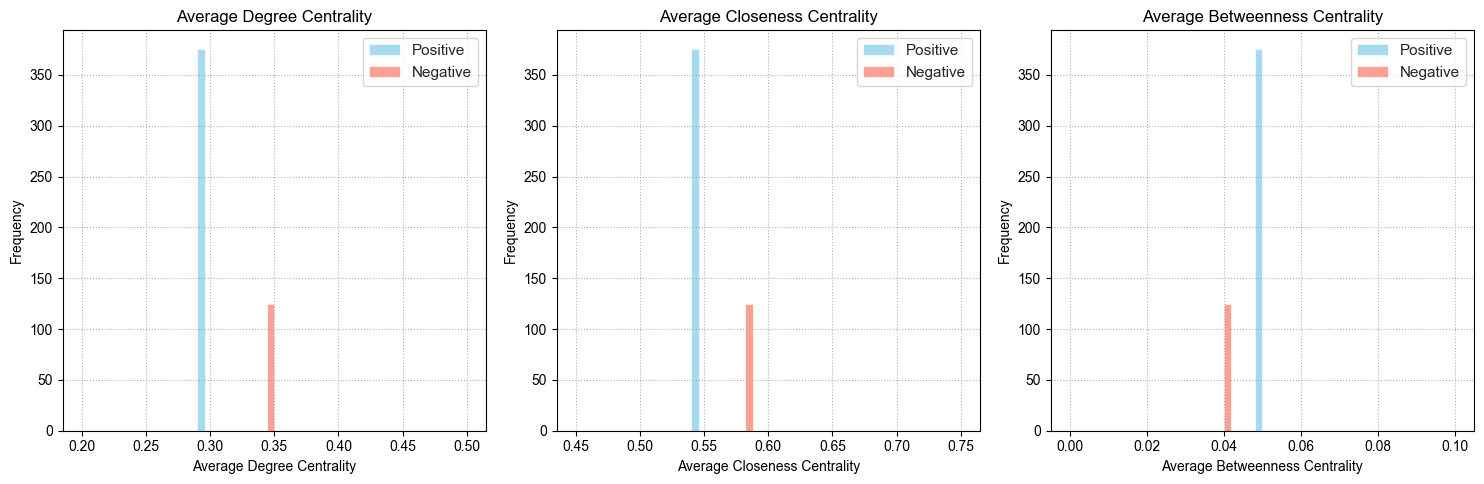

In [5]:
# Store the adjacency matrices for each of the classes
A_pos = A[np.where(y==0)[0]]
A_neg = A[np.where(y==1)[0]]

# Compute average degree centrality for each sample per class
deg_pos_mean = [get_avg_degree_centrality(a) for a in A_pos]
deg_neg_mean = [get_avg_degree_centrality(a) for a in A_neg]

# Compute average closeness centrality for each sample per class
cls_pos_mean = [get_avg_closeness_centrality(a) for a in A_pos]
cls_neg_mean = [get_avg_closeness_centrality(a) for a in A_neg]

# Compute average betweenness centrality for each sample per class
btw_pos_mean = [get_avg_betweenness_centrality(a) for a in A_pos]
btw_neg_mean = [get_avg_betweenness_centrality(a) for a in A_neg]


# Combine data and metrics into lists
pos_data = [deg_pos_mean, cls_pos_mean, btw_pos_mean]
neg_data = [deg_neg_mean, cls_neg_mean, btw_neg_mean]
metrics = ['Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality']
binranges = [(0.2, 0.5), (0.45, 0.75), (0, 0.1)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
# Iterate over the data and metrics to create each subplot
for i, (pos, neg, metric, binrange) in enumerate(zip(pos_data, neg_data, metrics, binranges)):
        _ = histogram_classes(pos, neg, metric, ax=axes[i], bins=50, binrange=binrange)  

fig.tight_layout()  # Adjust subplots to fit into figure area.
fig.savefig(fig_path / 'histogram.png')  # Save the figure before showing it.

Apparently, we can already differentiate between positive and negative based on just the graph structure. **A perfect classifier just using a threshold**, do we even need any GNNs after this? We will further analyze the node features to see if there is a similar way to distinguish between the classes and apply some SOTA GNN models.

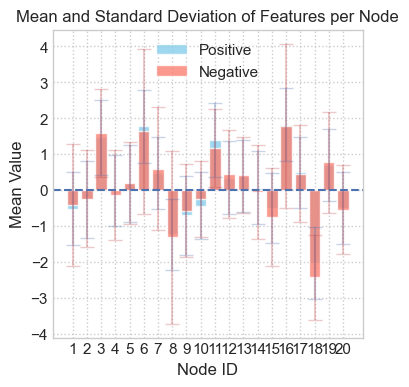

In [6]:
# plot the bars of mean and with std values
x_pos = x[np.where(y==0)[0]].squeeze()
x_neg = x[np.where(y==1)[0]].squeeze()

save_path = fig_path / 'bar_plot.png'
feature_bar_plots(x_pos, x_neg, save_path)

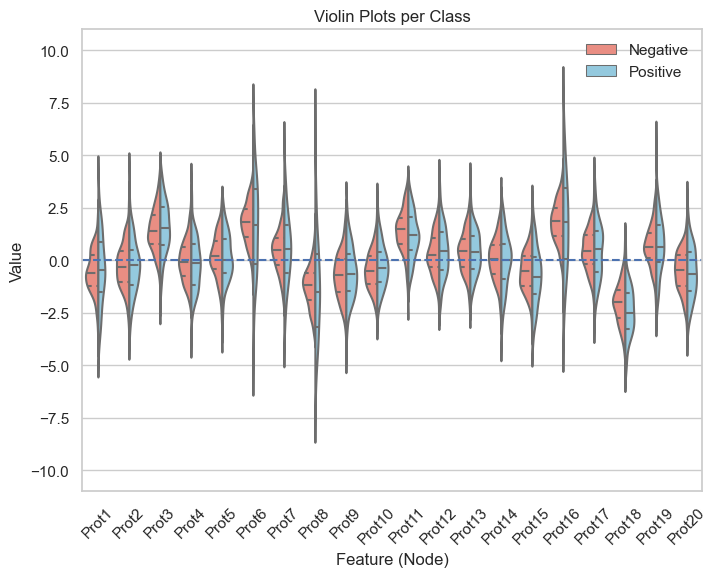

In [7]:
# Plot the violin plot of the features
df_melted = pd.melt(data, id_vars=['class'], 
                    value_vars=[f'Prot{i}' for i in range(1, N+1)], 
                    var_name='Protein', value_name='Expression')
                                                                                                                                                                                                                                                                                                                                                                                                   
save_path = fig_path / 'violins.png'
violin_plots(df_melted, save_path)

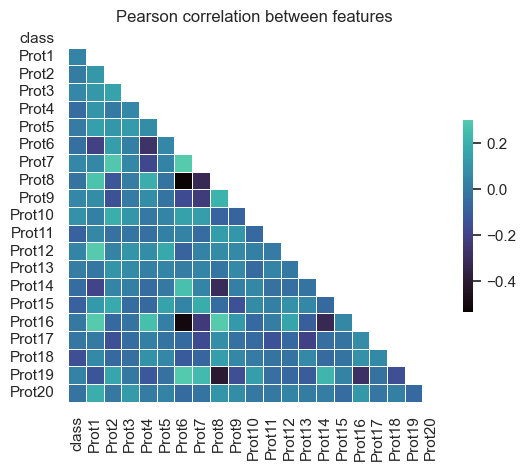

In [8]:
# Plot the correlation between the features
corr = data.iloc[:, 2:].corr()

save_path = fig_path / 'correlation.png'
corr_mtrx = corr_mtrx(corr, save_path)

The features seem to have a Gaussian distribution. They do not provide a strong correlation with the **class** target, although some features, such as **Prot18**, **Prot11** seem to be more correlated, which is confirmed by the violin plots, which show a small difference in the mean values per class.

#### 2.2 Edges statistics

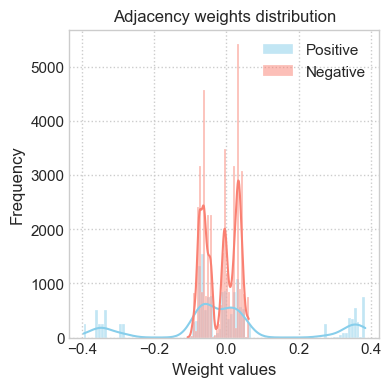

In [9]:
# Plot weights distribution of adjacency matrices
A_pos = A[np.where(y==1)[0]]
A_neg = A[np.where(y==0)[0]]

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(4, 4))
ax = histogram_classes(A_pos[A_pos!=0], A_neg[A_neg!=0], None, ax, kde=True)

ax.set_title('Adjacency weights distribution')
ax.set_xlabel('Weight values')

save_path = fig_path / 'Adj_weights_distr.png'
if save_path is not None:
    plt.savefig(save_path)
plt.show()

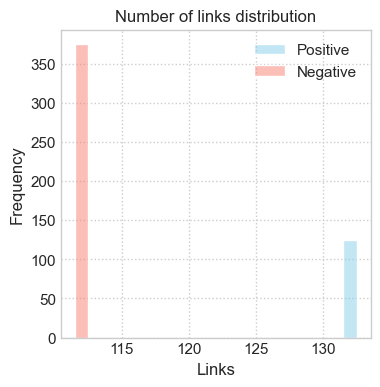

In [10]:
# Plot the distribution of the number of links per graph
num_links_pos = np.count_nonzero(A, axis=(1, 2))[np.where(y==1)[0]]
num_links_neg = np.count_nonzero(A, axis=(1, 2))[np.where(y==0)[0]]

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(4, 4))
ax = histogram_classes(num_links_pos, num_links_neg, None, ax, kde=True)

ax.set_title('Number of links distribution')
ax.set_xlabel('Links')

save_path = fig_path / 'Num_links_distr.png'
if save_path is not None:
    plt.savefig(save_path)
plt.show()

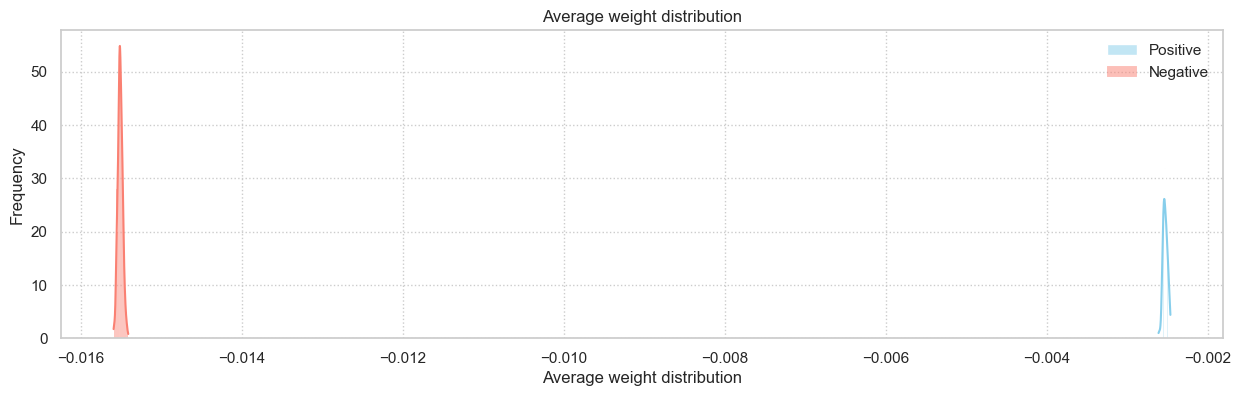

In [11]:
# Plot the distribution of an average weight per matrix
weights_pos = [a[a!=0].mean() for a in A_pos]
weights_neg = [a[a!=0].mean() for a in A_neg]

fig, ax = plt.subplots(figsize=(15, 4))
ax = histogram_classes(weights_pos, weights_neg, 'weight distribution', ax, kde=True)
save_path = fig_path / 'avg_weight_distr.png'
if save_path is not None:
    plt.savefig(save_path)
plt.show()

First observation is that the adjacency matrix contains negative weights, which has to be taken into account. Likely, it represents some correlation between the nodes, although the information is not provided in the dataset description. Secondly, similarly to the analysis of the nodes, by looking at the number of links per graph or by looking at the average link weight per graph, we can again perfectly separate the classes without any machine learning models.

#### 2.3 General graphs visualization

Graph 1, Negative class


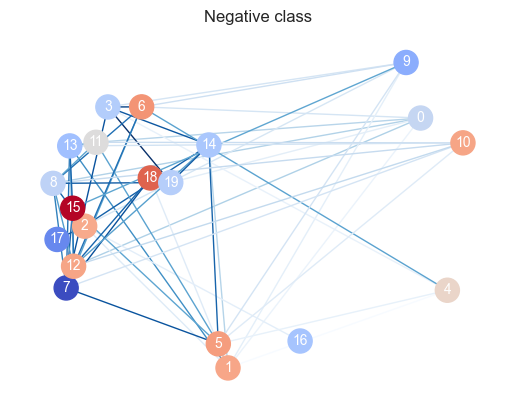

In [12]:
# Visualize one graph and color the nodes according to the feature values
idx = 0
label = 'Positive' if y[idx]==1 else 'Negative'

print(f'Graph {idx+1}, {label} class')

save_path = fig_path / f'graph_{label}.png'
vis_graph(A[idx], x[idx, :, 0], label, save_path)


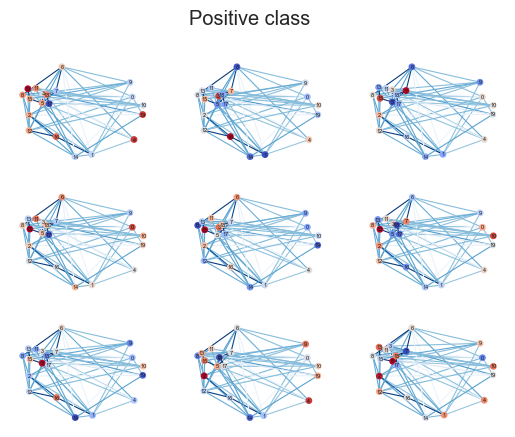

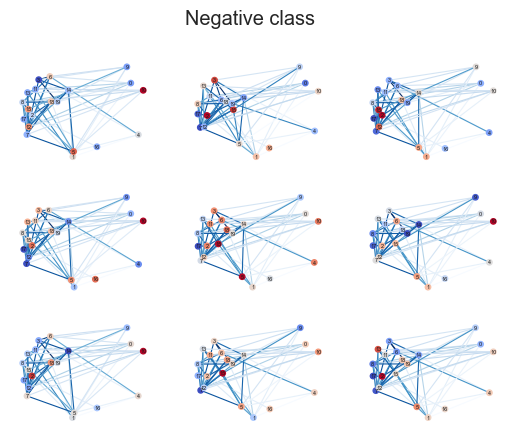

In [13]:
# Plot a few graphs of both classes together
save_path = fig_path / f'positive_graphs_{label}.png'
plot_graphs(A, x, y, 9, 'Positive', save_path)
save_path = fig_path / f'negative_graphs_{label}.png'
plot_graphs(A, x, y, 9, 'Negative', save_path)

The general topology of a given class seen to be also sufficient for the class separation. There might have been some errors with the simulation of the provided graphs, as the topology seems to be constant within the class. In any case, we will check how the neural networks will manage to solve the classification problem and weather they will leverage the observed patterns or not.

### 3 Data Preprocessing

This block provides all the necessary preprocessing required for the data. By setting the flags, you can modify the data the following way:

- `SCALE_ADJ_WEIGHTS`: convert the non-zero elements of adjacency matrix $A_i$ from range $[a_i^{min}, a_i^{max}]$, to $[\dfrac{1}{a_i^{max}-a_i^{min}+1}, 1]$ for graph $i$.
- `NORMALIZE_FEATURES`: apply standard scaling to the original features to have the distribution of the node features is Gaussian with zero mean and unit variance.
- `ADD_OHE_FEATURES`: for each node append $N$ features representing the one-hot-encoding of the node index.
- `ADD_NODE2VEC`: apply the [Node2Vec](https://arxiv.org/abs/1607.00653) to each of the graph to embed the node in a vector of size *dim* and append the result to the feature matrix.

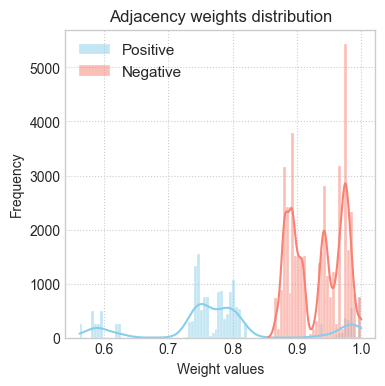

Number of samples: Training 350 | Validation 75 | Testing 75


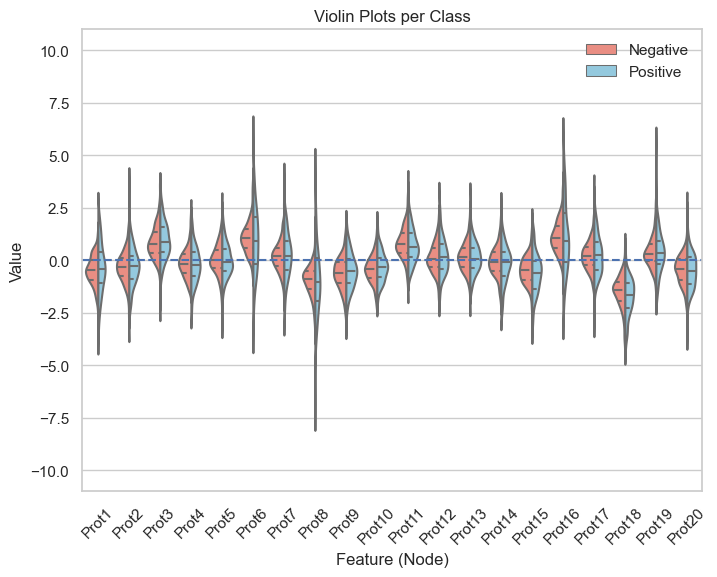

In [5]:
SCALE_ADJ_WEIGHTS = True
ADD_OHE_FEATURES = False
NORMALIZE_FEATURES = True 
ADD_NODE2VEC = False


if SCALE_ADJ_WEIGHTS:
    # Scale the weights of the adjacency matrices
    A = scale_adj(A)    

     # Plot weights distribution of adjacency matrices
    A_pos = A[np.where(y==1)[0]]
    A_neg = A[np.where(y==0)[0]]

    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(4, 4))
    ax = histogram_classes(A_pos[A_pos!=0], A_neg[A_neg!=0], None, ax, kde=True)

    ax.set_title('Adjacency weights distribution')
    ax.set_xlabel('Weight values')

    save_path = fig_path / 'Adj_weights_distr_norm.png'
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
    
if ADD_OHE_FEATURES:
    # Add the identifiers of each node as a OHE feature
    x = pad_ohe_features(x, N)
    # Number of features is increased by the number of nodes
    M += N
    
# Split the data into train, validation, and test sets
train_mask, val_mask, test_mask = get_train_val_test_masks(S, y)

if NORMALIZE_FEATURES:  
    # Standardize the features from a list features_id 
    features_id = [0] # list of features (columns) you want to scale
    for feature_id in features_id:
        x = scale_feature(x, feature_id, train_mask, val_mask, test_mask)
        
        # check the distribution
        data_scaled = np.hstack((x[:, :, feature_id], y))
        
        df = pd.DataFrame(data=data_scaled, columns=list(data.columns[3:]) + [data.columns[2]]) # set the columns in the cirrect order
        df_melted1 = pd.melt(df, id_vars=['class'], 
                            value_vars=[f'Prot{i}' for i in range(1, 21)], 
                            var_name='Protein', value_name='Expression')
        
        save_path = fig_path / f'violins_norm_{feature_id}.png'                                                                                                                                                                                                                                                                                                                                                              
        violin_plots(df_melted1, save_path)
        
if ADD_NODE2VEC:
    dim = 32

    from tqdm import tqdm
    from node2vec import Node2Vec

    x = torch.concat((torch.tensor(x, dtype=torch.float32), torch.zeros((x.shape[0], x.shape[1], dim), dtype=torch.float32)), dim=-1).to(device)

    for i in tqdm(range(A.shape[0])):
        # embedding for each graph
        G = nx.from_numpy_array(A[i])
        node2vec = Node2Vec(G, dimensions=dim, walk_length=20, num_walks=100, p=2, q=1, workers=20, quiet=True)
        model = node2vec.fit(window=10, min_count=1, batch_words=4)
        x[i, :, 1:] = torch.tensor(model.wv[np.arange(N)], dtype=torch.float32)
    M += dim
        #print(model.wv[np.arange(N)].shape)
    
    print('x.shape:', x.shape)


### 4 Deep Learning Graph Classification

This section will implement different graph neural network (GNN) model for the classification task. Some of the models, such as `GNN`, `GCN` and `GAT` are also provided in a complete implementation, as well as the off-the-shelf layers from [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/index.html). We further compare these models with the `MLP` model, which uses concatenated node features as input without taking into account the topology of the dataset. Each simulation is performed `num_sim` times to account for some randomness in the system (e.g. initialization, batch sampling and gradient update, etc.).

In [6]:
# Set the parameters for the simulation 
epochs = 300
batch_size = 64
num_sim = 5
num_layers = 2
dim_h = 16 # output dimension of the hidden layer
dropout = True

#### 4.0 MLP
As a baseline model, we can firs us a classic MLP architecture, which completely ignores any topology of the dataset.

In [18]:
# Create datasets and convert to mini-batches
train_loader = DatasetTabular(x[train_mask], y[train_mask], device).to_loader(batch_size=batch_size, shuffle=True)
val_loader = DatasetTabular(x[val_mask], y[val_mask], device).to_loader(batch_size=batch_size, shuffle=True)
test_loader = DatasetTabular(x[test_mask], y[test_mask], device).to_loader(batch_size=batch_size, shuffle=True)

Number of samples in the dataset: 350
Number of samples in the dataset: 75
Number of samples in the dataset: 75


c:\Users\useva\MyFiles\Projects\gnn-aslcd\Dataset\tabular.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x.reshape((x.shape[0], -1)), dtype=torch.float32).to(device)


In [19]:
mlp = MLP(dim_in=N*M, dim_h=dim_h, num_layers=num_layers, dropout=True).to(device)
print(mlp)
history_avg, history_test = test_n_times(mlp, train_loader, val_loader, test_loader, epochs, num_sim, verbose=True)
results['MLP'] = (history_avg, history_test)

MLP(
  (linear): ModuleList(
    (0): Linear(in_features=660, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
  )
  (classifier): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
Trial 1, test loss: 0.00 | test accuracy: 100.00%
Trial 2, test loss: 0.00 | test accuracy: 100.00%
Trial 3, test loss: 0.00 | test accuracy: 100.00%
Trial 4, test loss: 0.00 | test accuracy: 100.00%
Trial 5, test loss: 0.00 | test accuracy: 100.00%


#### 4.1 Prepare a graph dataset

For the following sections we will use the different representation of the dataset. While te `DatasetTabular` required classic input of *x* and *y*, the `DatasetGraph` requires `data_list` as input, where each element of the list is a [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html) object acquired from a specific graph.

In [7]:
data_list = to_data_list(A, x, y, device)
dataset = DatasetGraph(root='./Data', data_list=data_list) # delete the folder to reset

train_loader = dataset[train_mask].to_loader(batch_size=batch_size, shuffle=True)
val_loader = dataset[val_mask].to_loader(batch_size=batch_size, shuffle=True)
test_loader = dataset[test_mask].to_loader(batch_size=batch_size, shuffle=True)

Number of samples in the dataset: 500


Processing...
Done!


#### 4.2 GNN (manual)

A generic extension of `MLP` where the information for each node is aggregated with respect to its neighbors specified in the adjacency matrix. This is similar to the [following layer](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.SimpleConv.html#torch_geometric.nn.conv.SimpleConv).

In [21]:
gnn = GNN(dim_in=M, dim_h=dim_h, num_layers=num_layers, dropout=True).to(device)
print(gnn)
history_avg, history_test = test_n_times(gnn, train_loader, val_loader, test_loader, epochs, num_sim, verbose=True)
results['GNN (manual)'] = (history_avg, history_test)

VanillaGNNLayer(33, 16)
VanillaGNNLayer(16, 16)
Pooling: add
Linear(in_features=16, out_features=16, bias=True)
Linear(in_features=16, out_features=16, bias=True)
Linear(in_features=16, out_features=1, bias=True)

Trial 1, test loss: 0.62 | test accuracy: 82.46%
Trial 2, test loss: 0.66 | test accuracy: 77.13%
Trial 3, test loss: 0.40 | test accuracy: 83.88%
Trial 4, test loss: 0.26 | test accuracy: 92.97%
Trial 5, test loss: 0.54 | test accuracy: 80.89%


#### 4.3.1 GCN (manual)

The [layer](https://arxiv.org/abs/1609.02907) is designed to scale the contribution of each neighbor by its degree to avoid large values for 
nodes with large number of neighbors

In [22]:
gcn1 = GCN(dim_in=M, dim_h=dim_h, num_layers=num_layers, dropout=True, manual=True).to(device) 
print(gcn1)
history_avg, history_test = test_n_times(gcn1, train_loader, val_loader, test_loader, epochs, num_sim, verbose=True)
results['GCN (manual)'] = (history_avg, history_test)

VanillaGCNLayer(33, 16)
VanillaGCNLayer(16, 16)
Pooling: add
Linear(in_features=16, out_features=16, bias=True)
Linear(in_features=16, out_features=16, bias=True)
Linear(in_features=16, out_features=1, bias=True)

Trial 1, test loss: 0.31 | test accuracy: 89.99%
Trial 2, test loss: 0.21 | test accuracy: 92.97%
Trial 3, test loss: 0.30 | test accuracy: 90.77%
Trial 4, test loss: 0.30 | test accuracy: 86.22%
Trial 5, test loss: 0.24 | test accuracy: 93.75%


#### 4.3.2 GCN (PyG)

Same layer as discussed previously, but used from [PyG](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv).

In [23]:
gcn2 = GCN(dim_in=M, dim_h=dim_h, num_layers=num_layers, dropout=True).to(device) 
print(gcn2)
history_avg, history_test = test_n_times(gcn2, train_loader, val_loader, test_loader, epochs, num_sim, verbose=True)
results['GCN'] = (history_avg, history_test)

GCNConv(33, 16)
GCNConv(16, 16)
Pooling: add
Linear(in_features=16, out_features=16, bias=True)
Linear(in_features=16, out_features=16, bias=True)
Linear(in_features=16, out_features=1, bias=True)

Trial 1, test loss: 0.40 | test accuracy: 79.97%
Trial 2, test loss: 0.45 | test accuracy: 76.99%
Trial 3, test loss: 0.37 | test accuracy: 79.97%
Trial 4, test loss: 0.33 | test accuracy: 83.74%
Trial 5, test loss: 0.35 | test accuracy: 79.97%


#### 4.4 GraphConv

This [layer](https://arxiv.org/abs/1810.02244) was presented as a generalization of `GNNs` based on the `k-WL test`. The model is strictly stronger then `GNNs` in terms of distinguishing non-isomorphic (sub-)graphs.


In [24]:
gcn = GCONV(dim_in=M, dim_h=dim_h, num_layers=num_layers, dropout=True).to(device)
print(gcn)
history_avg, history_test = test_n_times(gcn, train_loader, val_loader, test_loader, epochs, num_sim, verbose=True)
results['GraphConv'] = (history_avg, history_test)

GraphConv(33, 16)
GraphConv(16, 16)
Pooling: add
Linear(in_features=16, out_features=16, bias=True)
Linear(in_features=16, out_features=16, bias=True)
Linear(in_features=16, out_features=1, bias=True)

Trial 1, test loss: 0.23 | test accuracy: 90.77%
Trial 2, test loss: 0.23 | test accuracy: 93.75%
Trial 3, test loss: 0.69 | test accuracy: 89.99%
Trial 4, test loss: 0.23 | test accuracy: 91.55%
Trial 5, test loss: 0.23 | test accuracy: 94.53%


#### 4.5.1 GAT (manual)

The goal of the [graph attention layer](https://arxiv.org/abs/2105.14491) is to produce weighting factors that also consider the importance of node features by a process called self-attention.

In [25]:
gat1 = GAT(dim_in=M, dim_h=dim_h, num_layers=num_layers, dropout=True, manual=True).to(device)
print(gat1)
history_avg, history_test = test_n_times(gat1, train_loader, val_loader, test_loader, epochs, num_sim, verbose=True)
results['GAT (manual)'] = (history_avg, history_test)

VanillaGATLayer(33, 16, heads=3, concat=True)
VanillaGATLayer(48, 16, heads=1, concat=False)
Pooling: add
Linear(in_features=16, out_features=16, bias=True)
Linear(in_features=16, out_features=16, bias=True)
Linear(in_features=16, out_features=1, bias=True)

Trial 1, test loss: 0.17 | test accuracy: 91.55%
Trial 2, test loss: 0.14 | test accuracy: 95.31%
Trial 3, test loss: 0.17 | test accuracy: 95.31%
Trial 4, test loss: 0.12 | test accuracy: 95.31%
Trial 5, test loss: 0.15 | test accuracy: 91.55%


#### 4.5.2 GAT (PyG)

Same layer as discussed previously, but used from [PyG](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATv2Conv.html#torch_geometric.nn.conv.GATv2Conv).

In [26]:
gat2 = GAT(dim_in=M, dim_h=dim_h, num_layers=num_layers, dropout=True).to(device)
print(gat2)
history_avg, history_test = test_n_times(gat2, train_loader, val_loader, test_loader, epochs, num_sim, verbose=True)
results['GAT'] = (history_avg, history_test)

GATv2Conv(33, 16, heads=3)
GATv2Conv(48, 16, heads=1)
Pooling: add
Linear(in_features=16, out_features=16, bias=True)
Linear(in_features=16, out_features=16, bias=True)
Linear(in_features=16, out_features=1, bias=True)

Trial 1, test loss: 0.21 | test accuracy: 90.77%
Trial 2, test loss: 0.17 | test accuracy: 93.89%
Trial 3, test loss: 0.06 | test accuracy: 98.44%
Trial 4, test loss: 0.09 | test accuracy: 97.66%
Trial 5, test loss: 0.15 | test accuracy: 97.66%


#### 4.6 GIN

The [layer](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GINConv.html#torch_geometric.nn.conv.GINConv) is the graph isomorphism operator, which is designed to increase the GNN expressivity.

In [27]:
gin = GIN(dim_in=M, dim_h=dim_h, num_layers=num_layers, dropout=True).to(device)
print(gin)
history_avg, history_test = test_n_times(gin, train_loader, val_loader, test_loader, epochs, num_sim, verbose=True)
results['GIN'] = (history_avg, history_test)

GINConv(nn=Sequential(
  (0): Linear(in_features=33, out_features=16, bias=True)
  (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=16, bias=True)
  (4): ReLU()
))
GINConv(nn=Sequential(
  (0): Linear(in_features=16, out_features=16, bias=True)
  (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=16, bias=True)
  (4): ReLU()
))
Pooling: add
Linear(in_features=32, out_features=32, bias=True)
Linear(in_features=32, out_features=32, bias=True)
Linear(in_features=32, out_features=1, bias=True)

Trial 1, test loss: 0.09 | test accuracy: 99.22%
Trial 2, test loss: 0.46 | test accuracy: 94.67%
Trial 3, test loss: 0.09 | test accuracy: 99.22%
Trial 4, test loss: 0.47 | test accuracy: 95.45%
Trial 5, test loss: 0.08 | test accuracy: 99.22%


#### 4.7 Performance comparison

Plot the validation accuracy and loss (averaged over the `num_sim`) and the final test performance. 

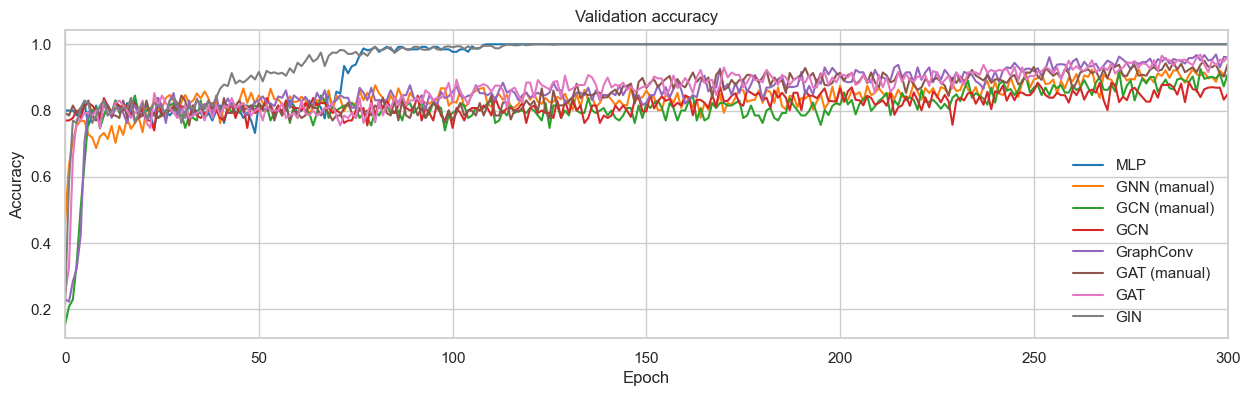

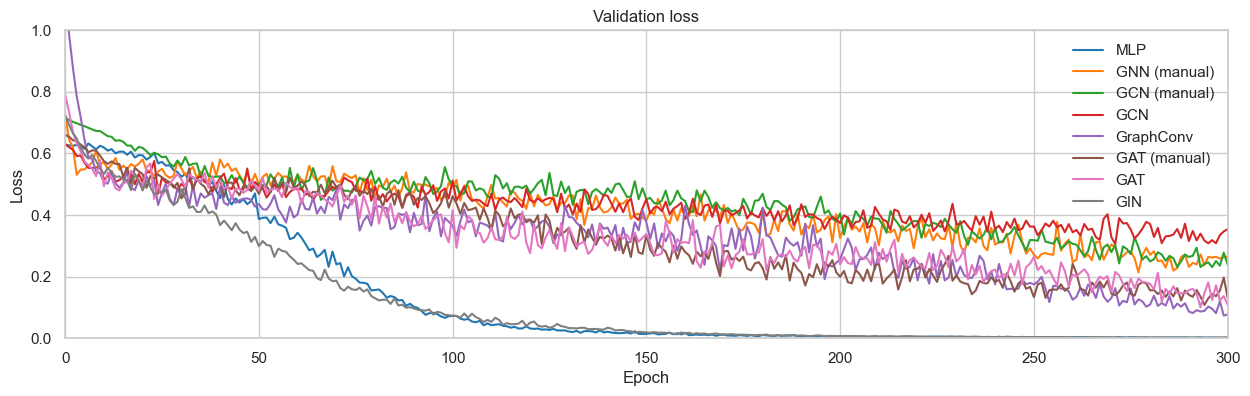

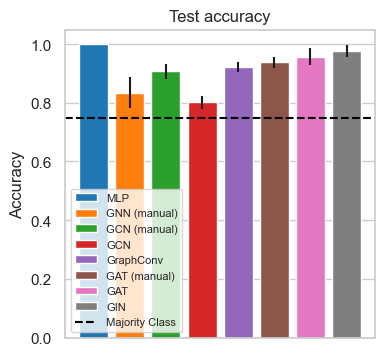

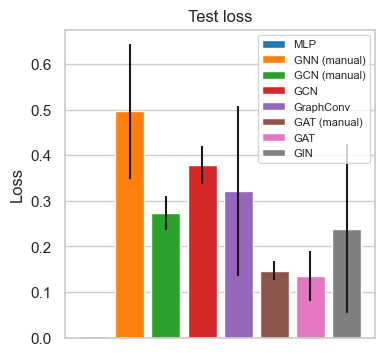

In [28]:
fig1, ax1 = plt.subplots(figsize=(15, 4)) # val performance (acc)
fig2, ax2 = plt.subplots(figsize=(15, 4)) # val performance (loss)
fig4, ax3 = plt.subplots(figsize=(4, 4)) # test performance (acc)
fig5, ax4 = plt.subplots(figsize=(4, 4)) # test_performance (loss)

colors = plt.get_cmap('tab10').colors

df_test = pd.DataFrame(columns=['Model', 'mean_loss', 'std_loss', 'mean_acc', 'std_acc'])
for i, (key, val) in enumerate(results.items()):
    history_val, test = val

    df_test.loc[len(df_test)] = [key, np.mean(test['test_loss']), np.std(test['test_loss']),
                    np.mean(test['test_acc']), np.std(test['test_acc'])]
    ax1.plot(history_val['val_acc'], label=key, color=colors[i])
    ax2.plot(history_val['val_loss'], label=key, color=colors[i])

ax1.legend()    
ax1.set_title('Validation accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_xlim([0, epochs])

ax2.legend()    
ax2.set_title('Validation loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_xlim([0, epochs])
ax2.set_ylim([0, 1])

ax3.bar(df_test['Model'], df_test['mean_acc'], yerr=df_test['std_acc'], label=df_test['Model'], 
        color=[colors[c] for c in range(len(df_test))])
ax3.axhline(y=baseline, color='black', linestyle='--', label='Majority Class') #, label='Baseline')
ax3.set_title('Test accuracy')
ax3.set_ylabel('Accuracy')
ax3.set_xticks([])
ax3.legend(frameon=True, loc='lower left', prop={'size': 8})  

ax4.bar(df_test['Model'], df_test['mean_loss'], yerr=df_test['std_loss'], label=df_test['Model'], 
        color=[colors[c] for c in range(len(df_test))])
ax4.set_title('Test loss')
ax4.set_ylabel('Loss')
ax4.set_xticks([])
ax4.legend(frameon=True, loc='upper right', prop={'size': 8})  

plt.show()    

The figures depend on the selected preprocessing in *section 3*. On observation, is if we use just the initial features, the `MLP` outperforms the majority of the models. This might happen, and a similar outcomes are found in [this](https://stackoverflow.com/questions/75752422/gnn-graph-classification-poor-performance) **stack overflow** discussion.

### 5 XAI: GNNExplainer and IntegratedGradients

To perform `XAI`, we'll use two popular explainers: [`Graph Neural Network Explainer (GNNE)` and `Integrated Gradients (IG)`](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/explain.html). The intuition behind `GNNExplainer` is to implements an edge mask and a feature mask to discard some of them. If the object is important, removing it should drastically change the prediction. `Integrated gradients` technique aims to assign an attribution score to every node and edge. To this end, it uses gradients with respect to the model’s inputs. It computes the gradients at all points along the path between and accumulates them. 


In [16]:
# Fit a model (Note: not the `manual` model)
model = GCN(dim_in=M, dim_h=dim_h, num_layers=num_layers, dropout=True).to(device)
_ = model.fit(train_loader, val_loader, epochs=300, verbose=True)

Epoch   0 | Train Loss: 0.794 | Train Acc: 25.57% | Val Loss: 0.82 | Val Acc: 15.48%
Epoch  20 | Train Loss: 0.714 | Train Acc: 24.43% | Val Loss: 0.72 | Val Acc: 15.48%
Epoch  40 | Train Loss: 0.614 | Train Acc: 75.31% | Val Loss: 0.60 | Val Acc: 80.75%
Epoch  60 | Train Loss: 0.571 | Train Acc: 75.90% | Val Loss: 0.57 | Val Acc: 76.99%
Epoch  80 | Train Loss: 0.578 | Train Acc: 74.43% | Val Loss: 0.53 | Val Acc: 80.75%
Epoch 100 | Train Loss: 0.570 | Train Acc: 74.72% | Val Loss: 0.58 | Val Acc: 73.22%
Epoch 120 | Train Loss: 0.561 | Train Acc: 75.31% | Val Loss: 0.50 | Val Acc: 80.75%
Epoch 140 | Train Loss: 0.567 | Train Acc: 74.43% | Val Loss: 0.46 | Val Acc: 84.52%
Epoch 160 | Train Loss: 0.560 | Train Acc: 74.72% | Val Loss: 0.46 | Val Acc: 84.52%
Epoch 180 | Train Loss: 0.547 | Train Acc: 75.61% | Val Loss: 0.53 | Val Acc: 76.99%
Epoch 200 | Train Loss: 0.551 | Train Acc: 75.02% | Val Loss: 0.53 | Val Acc: 76.99%
Epoch 220 | Train Loss: 0.541 | Train Acc: 75.61% | Val Loss: 0.5

Initialize the explainers with respect to our task (graph classification). 

In [18]:
# Initialize the Explainer (GNNE)
explainer_gnne = Explainer(
    model=copy.deepcopy(model),
    algorithm=GNNExplainer(epochs=100),
    explanation_type='model',
    node_mask_type='object',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='graph',
        return_type='log_probs',
    ),
)

# Initialize the Explainer (IG)
explainer_ig = Explainer(
    model=copy.deepcopy(model),
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='graph',
        return_type='log_probs',
    ),
    threshold_config=dict(
        threshold_type='topk',
        value=100,
    ),
)

Select an index `ind` of a sample which you would like to investigate. Save the class of the sample as a string and store the edge and node masks. By default, these masks represent preprocessed features of the original graph, while for the explainers the output is the assigned scores for each of the component. For `IG` we average the score of the output features of nodes for visualization purposes. 

In [19]:
# Initialize the original graph
ind = 2
data = dataset[ind]
label = 'Positive' if data.y==1 else 'Negative'
print(label)

G = nx.from_numpy_array(A[ind])#to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=0)

# Original graph attributes
edge_mask = np.array([G[u][v]['weight'] for u, v in G.edges]) # edge weights
node_mask = data.x[:, 0].detach().cpu().numpy() # features 

# Get explanations for the graph (targeting the entire graph)
explanation_gnne = explainer_gnne(data.x, data.edge_index, edge_weight=data.edge_weight, batch=None)
explanation_ig = explainer_ig(data.x, data.edge_index, edge_weight=data.edge_weight, batch=None)

# Access the node and edge masks from the explanations
edge_mask_gnne = explanation_gnne.edge_mask.detach().cpu().numpy()
node_mask_gnne = explanation_gnne.node_mask.detach().cpu().numpy()

edge_mask_ig = explanation_ig.edge_mask.detach().cpu().numpy()
node_mask_ig = explanation_ig.node_mask.mean(dim=1).unsqueeze(dim=-1).detach().cpu().numpy()#.node_mask.detach().cpu().numpy()

Positive


Visualize the graph topology using 
- `Original` edge weights and node features 
- `GNNExplainer` edge and node masks
- `Integrated Gradients` edge and node masks

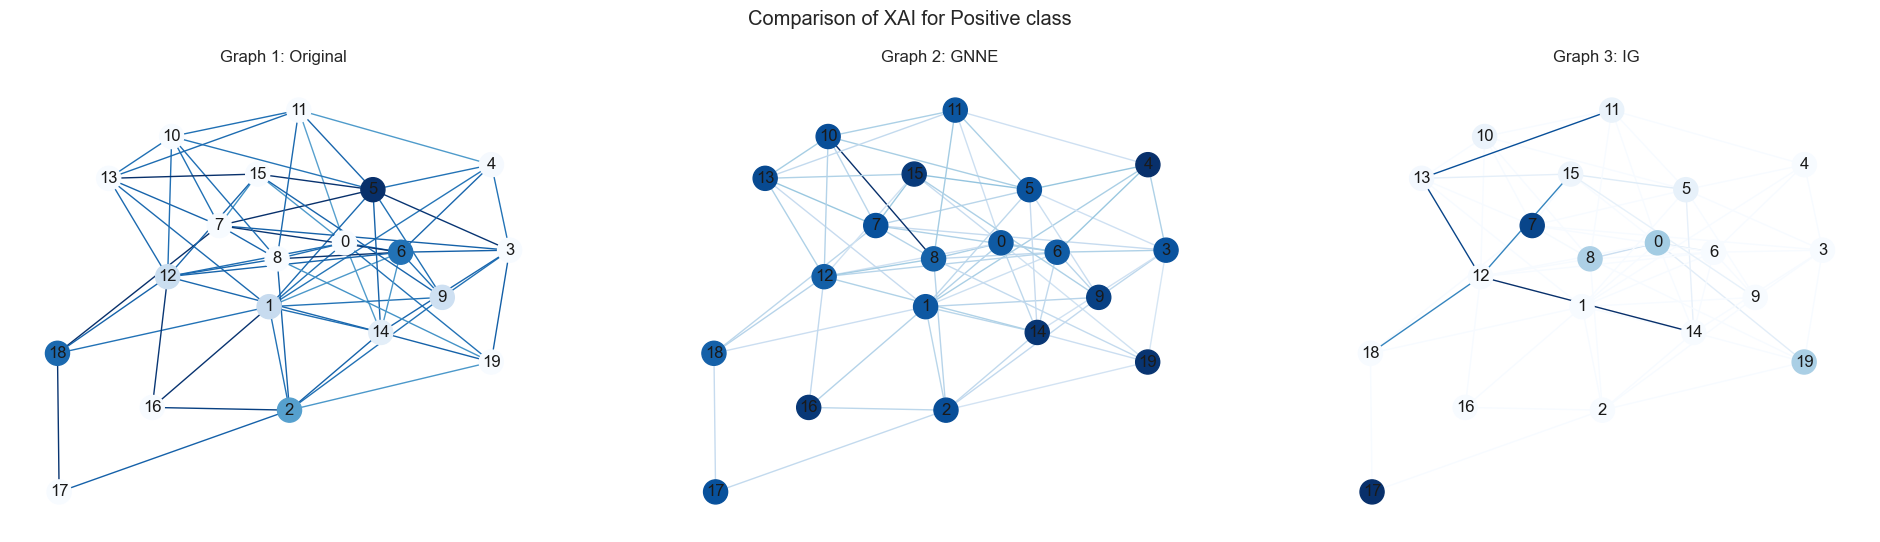

In [20]:
# Apply a colormap to the edge_mask to get RGBA values
cmap = plt.cm.Blues

edge_colors = cmap(edge_mask / edge_mask.max())
node_colors = cmap(node_mask / node_mask.max())

edge_colors_gnne = cmap(edge_mask_gnne / edge_mask_gnne.max())
node_colors_gnne = cmap(node_mask_gnne / node_mask_gnne.max())

edge_colors_ig = cmap(edge_mask_ig / edge_mask_ig.max())
node_colors_ig = cmap(node_mask_ig / node_mask_ig.max())


# Create a figure with 3 subplots (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

# Turn off axes for each subplot
for ax in axs:
    ax.axis('off')

# Plot the first graph
nx.draw(
    G, 
    pos, 
    node_size=300, 
    with_labels=True, 
    edge_color=edge_colors, 
    node_color=node_colors,
    ax=axs[0]
)
axs[0].set_title("Graph 1: Original")

# Plot the second graph
nx.draw(
    G, 
    pos, 
    node_size=300, 
    with_labels=True, 
    edge_color=edge_colors_gnne,  
    node_color=node_colors_gnne,
    ax=axs[1]
)
axs[1].set_title("Graph 2: GNNE")

# Plot the third graph
nx.draw(
    G, 
    pos, 
    node_size=300, 
    with_labels=True, 
    edge_color=edge_colors_ig,
    node_color=node_colors_ig,
    ax=axs[2]
)
axs[2].set_title("Graph 3: IG")

# Show the plot with the subfigures
plt.suptitle(f"Comparison of XAI for {label} class")
plt.show()